#### 📂 Practical Lab 1

#### Streaming Data for Predictive Maintenance with Linear Regression-Based Alerts

In the data_stream_visualization workshop, the robot current data were ingested from the given CSV file and 150 rows were inserted into the database. 

In this workshop, all those rows will be retreived from the database and be used for Predictive Maintenance with Linear Regression-Based Alerts

🔍 Discovering Thresholds

We are not given fixed thresholds. Instead, we must discover them from the data.

To get the thresholds:
1.	Develop regression models:
* For each axis (#1–#8), fit (train) a univariate linear regression (Time → Axis values) and produce a model able to make predictions when fed testing data (read below)
* Record slope and intercept.
* Plot scatter data with regression lines.

#### 2. Analyze residuals

* Compute the difference between observed values and the regression prediction.
* Plot distributions (scatter, line, or boxplots of residuals).
* Look for outliers and patterns.

Step 1: Fits regressions (time → Axis #1–#8).

Step 2: Computes residuals = observed − predicted.

Step 3: Plots residual scatter plots, line plots, and boxplots for each axis.

Step 4: Highlights potential outliers.

#### 3.	Define thresholds:

* Choose MinC: the minimum current deviation (kWh above regression line) that should trigger an Alert if sustained.
* Choose MaxC: the maximum current deviation (kWh above the regression line) that should trigger an Error if sustained.
* Choose T: the minimum continuous time (in seconds) that the deviation must persist.


Step 1: Fit linear regressions (time → Axis #1–#8).

Step 2: Compute residuals = observed − predicted.

Step 3: Define thresholds:

    - MinC = minimum deviation above regression line → triggers Alert if sustained.

    - MaxC = maximum deviation above regression line → triggers Error if sustained.

    - T = minimum continuous duration (in seconds) that residuals must stay above threshold.

Step 4: Detect events where these conditions hold.


In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
from IPython.display import clear_output, display

from sqlalchemy import create_engine
from urllib.parse import quote_plus

import importlib

import modules.DBManager
importlib.reload(modules.DBManager)

import modules.FileManager
importlib.reload(modules.FileManager)

import os


In [143]:
# === Fetching data from db to use for training the model ===
dbmanager = modules.DBManager.DBManager(columns=[])
df_train = dbmanager.fetch_all()

# Keep only time and Axis #1–#8 columns
axis_cols = [f"Axis #{i}" for i in range(1, 9)]
df_train = df_train[["time"] + axis_cols].copy()

# Path to the CSV file containing the synthetic regression testing data
csv_path = "./data/synthetic_regression_testing_data.csv"
# Loads the data from a CSV file.
fileManager = modules.FileManager.FileManager(csv_path)
df_test = fileManager.get_data()
columns = fileManager.get_columns()

# uncomment to see the first few rows of the testing dataframe
# df_test.head() 

# uncomment to see the first few rows of the training dataframe
# df_train.head() 


c:\Users\MOSTAFA\Desktop\Foundations of ML Frameworks\Practical Lab 1\Predictive-Maintenance-with-Linear-Regression\modules\DBManager.py:65: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, conn)


✅ Successfully loaded 150 rows from robot_readings table.
✅ Successfully loaded 39672 rows from ./data/synthetic_regression_testing_data.csv


✅ Successfully wrote data to ./results/regression_coefficients.csv


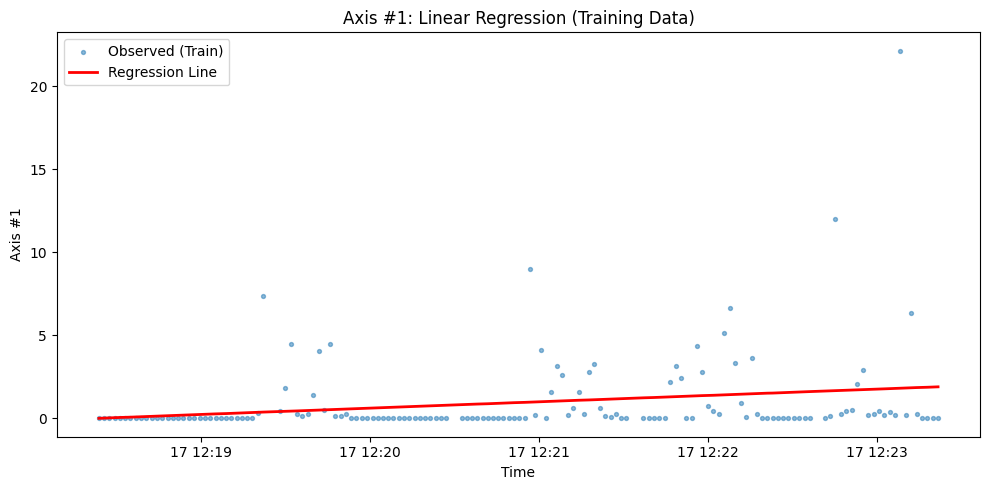

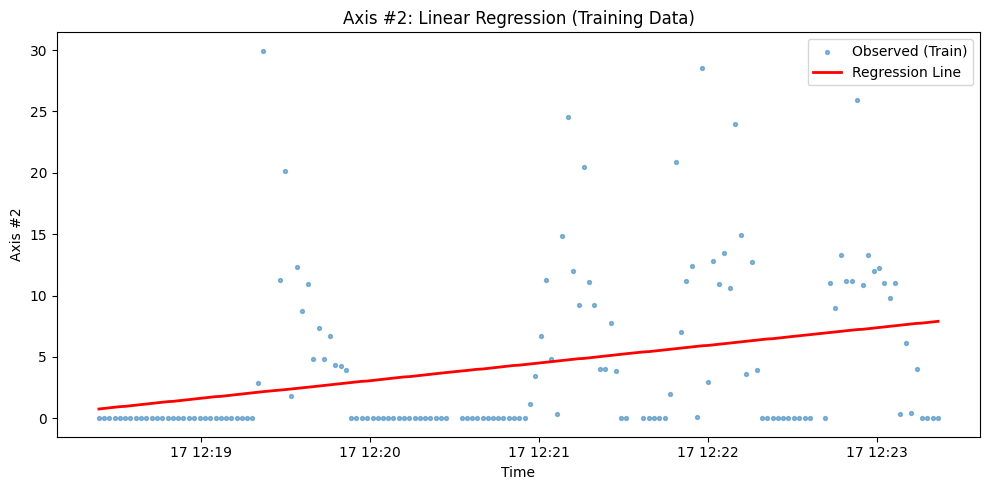

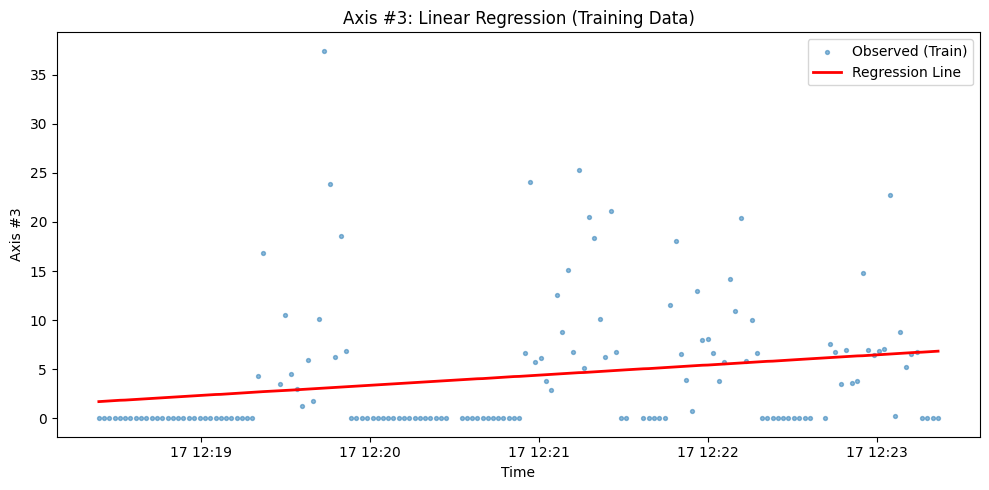

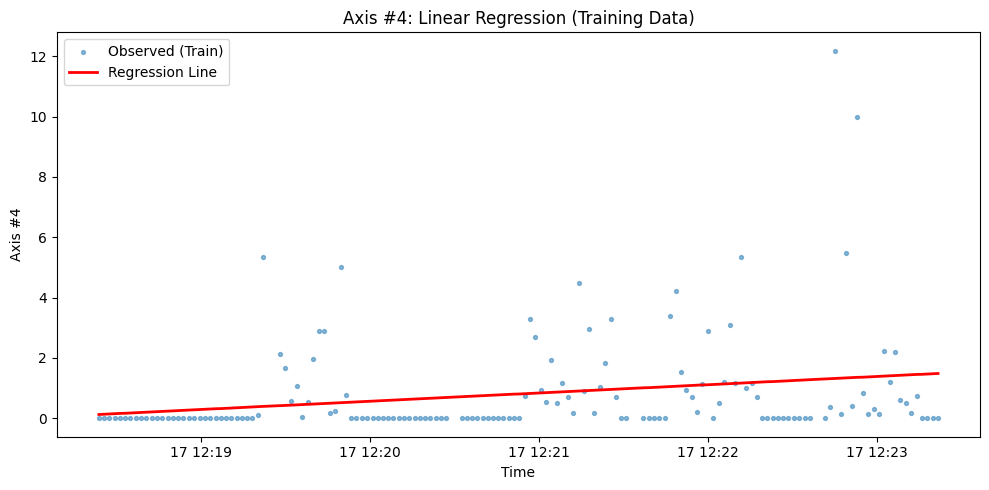

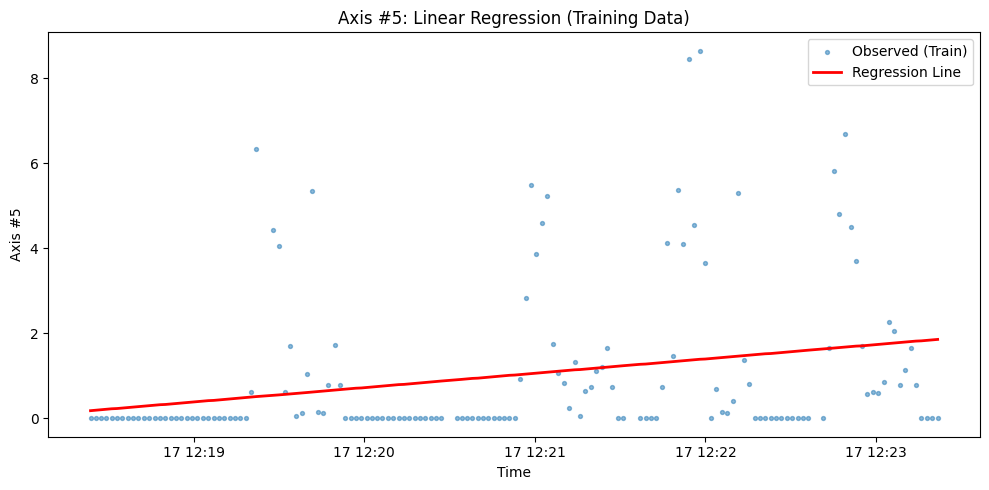

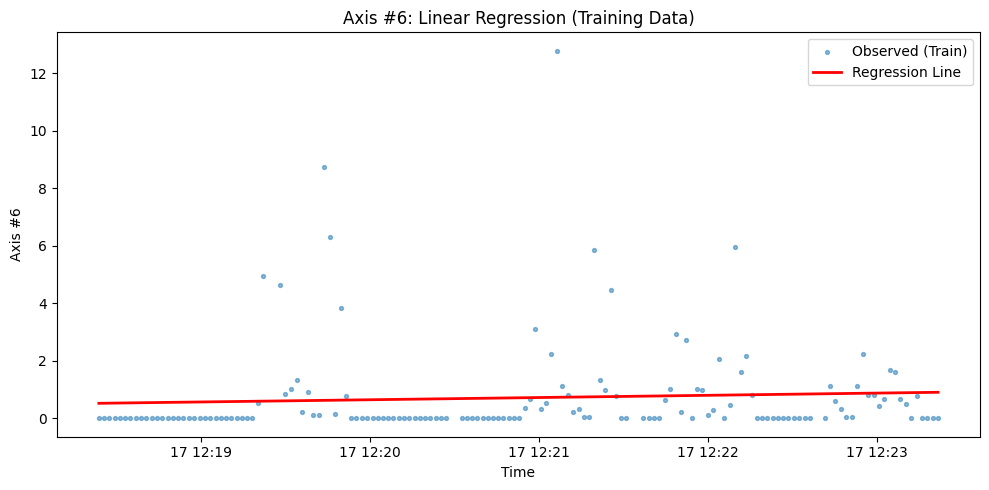

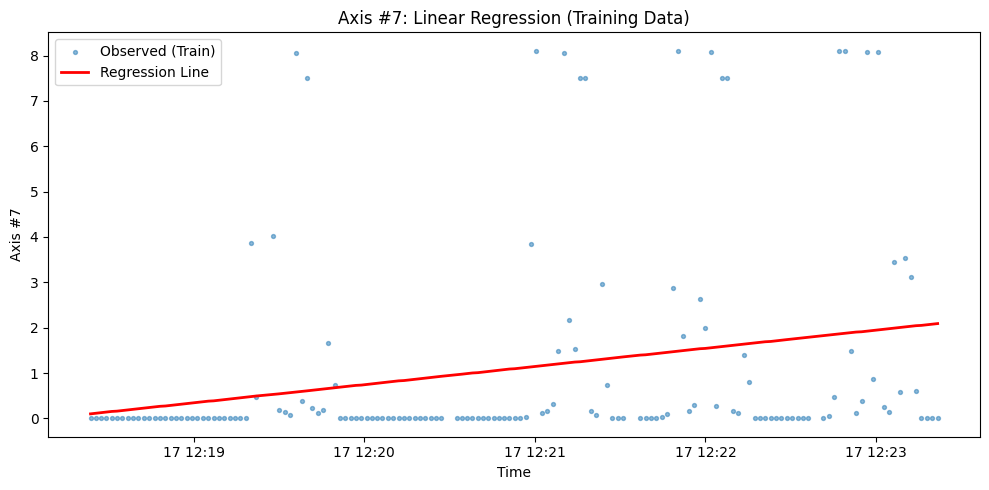

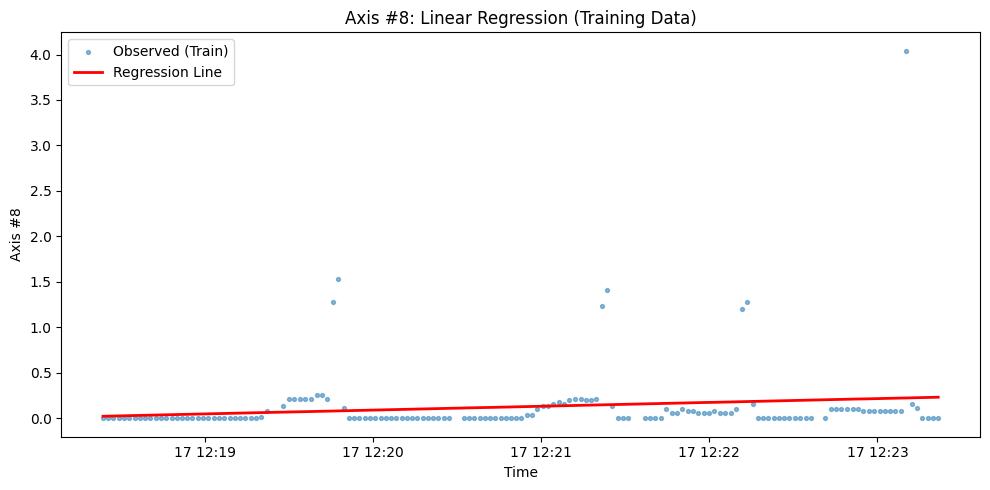

In [144]:
# Convert time to datetime and numeric (UNIX timestamp in seconds)
df_train["time"] = pd.to_datetime(df_train["time"], errors="coerce")
df_train["time_numeric"] = df_train["time"].astype(np.int64) // 10**9 # epoch time in seconds

df_test["time"] = pd.to_datetime(df_test["time"], errors="coerce")
df_test["time_numeric"] = df_test["time"].astype(np.int64) // 10**9 # epoch time in seconds

x_train = df_train[["time_numeric"]].values # used for x axis in regression values

# === Thresholds ===
T = 300   # seconds continuous
MinC_manual = None   # e.g. set = 5.0 (kWh) to override auto
MaxC_manual = None   # e.g. set = 10.0 (kWh) to override auto

# === Train the models ===
models = {}
coeffs = []

for c in axis_cols:
    y_train = df_train[c].values
    model = LinearRegression()
    model.fit(x_train, y_train)
    models[c] = model
    coeffs.append({
        "Axis": c,
        "Intercept": round(float(model.intercept_), 9),
        "Slope": round(float(model.coef_[0]), 9)
    })

coeffs_df = pd.DataFrame(coeffs)
fileManager.write_csv("./results/regression_coefficients.csv", coeffs_df)

# === 4. Plot scatter + regression line for each Axis ===
# === Display and save plots to results/plots folder ===

plot_dir = "./results/plots"
os.makedirs(plot_dir, exist_ok=True)

for c in axis_cols:
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Scatter observed training data
    ax.scatter(df_train["time"], df_train[c], s=8, alpha=0.5, label="Observed (Train)")
    
    # Regression line - I am using training data here to show the regression line in the plots
    y_pred = models[c].predict(x_train)
    ax.plot(df_train["time"], y_pred, color="red", linewidth=2, label="Regression Line")
    
    ax.set_title(f"{c}: Linear Regression (Training Data)")
    ax.set_xlabel("Time")
    ax.set_ylabel(c)
    ax.legend()
    plt.tight_layout()
    plt.show()
    fig.tight_layout()
    fig.savefig(os.path.join(plot_dir, f"{c.replace(' ', '_')}_train_regression.png"))
    plt.close(fig)

# coeffs_df.head()  # uncomment to see the first few rows of the coefficients dataframe


✅ Successfully wrote data to ./results/alerts_errors.csv

No Alert/Error events detected.


KeyError: 'Axis'

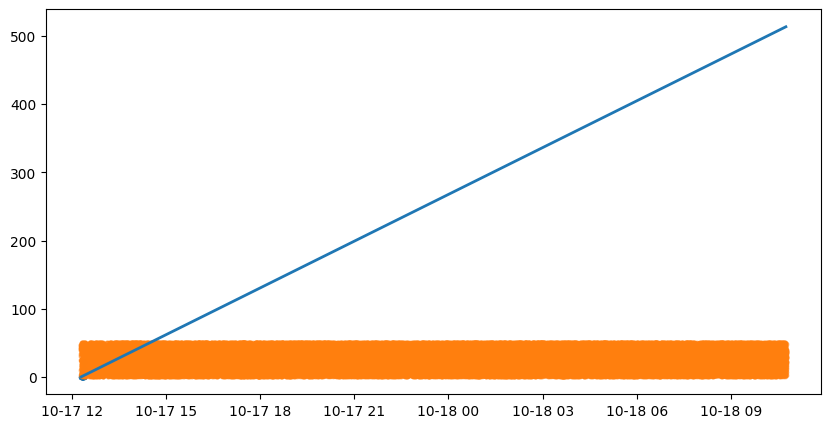

In [145]:

# Predictions on test data

X_test = df_test[["time_numeric"]].values
preds = pd.DataFrame({"time": df_test["time"]})

for c in axis_cols:
    preds[c + " Pred"] = models[c].predict(X_test)
    preds[c + " Obs"] = df_test[c].values
    preds[c + " Resid"] = preds[c + " Obs"] - preds[c + " Pred"]

# Residuals summary
resid_stats = []
for c in axis_cols:
    r = preds[c + " Resid"]
    resid_stats.append({
        "Axis": c,
        "Mean": float(r.mean()),
        "STD": float(r.std()),
        "Median": float(r.median()),
        "Q1": float(r.quantile(0.25)),
        "Q3": float(r.quantile(0.75))
    })
resid_stats_df = pd.DataFrame(resid_stats)
resid_stats_df.to_csv("./results/residuals_summary.csv", index=False)

# Thresholds (manual or auto)
thresholds = {}
for c in axis_cols:
    std = preds[c + " Resid"].std()
    thresholds[c] = {
        "MinC": MinC_manual if MinC_manual is not None else 2.0 * std,
        "MaxC": MaxC_manual if MaxC_manual is not None else 3.0 * std
    }

    
# Detect Alert/Error events
events = []
for c in axis_cols:
    r = preds[c + " Resid"].values
    tnum = df_test["time_numeric"].values
    tdt = df_test["time"].values
    minc = thresholds[c]["MinC"]
    maxc = thresholds[c]["MaxC"]
    i = 0
    n = len(r)
    while i < n:
        if r[i] >= minc:
            s = i
            while i < n and r[i] >= minc:
                i += 1
            e = i - 1
            duration = int(tnum[e] - tnum[s])
            if duration >= T:
                # Look for error subsegments
                sub_i = s
                error_segs = []
                while sub_i <= e:
                    if r[sub_i] >= maxc:
                        ss = sub_i
                        while sub_i <= e and r[sub_i] >= maxc:
                            sub_i += 1
                        ee = sub_i - 1
                        sub_dur = int(tnum[ee] - tnum[ss])
                        if sub_dur >= T:
                            error_segs.append((ss, ee, sub_dur))
                    else:
                        sub_i += 1
                if error_segs:
                    for seg in error_segs:
                        ss, ee, sd = seg
                        events.append({
                            "Axis": c, "Type": "ERROR",
                            "start_time": str(pd.to_datetime(tdt[ss])),
                            "end_time": str(pd.to_datetime(tdt[ee])),
                            "duration_s": int(sd),
                            "max_residual": float(r[ss:ee+1].max()),
                            "mean_residual": float(r[ss:ee+1].mean())
                        })
                else:
                    events.append({
                        "Axis": c, "Type": "ALERT",
                        "start_time": str(pd.to_datetime(tdt[s])),
                        "end_time": str(pd.to_datetime(tdt[e])),
                        "duration_s": int(duration),
                        "max_residual": float(r[s:e+1].max()),
                        "mean_residual": float(r[s:e+1].mean())
                    })
        else:
            i += 1

events_df = pd.DataFrame(events)
fileManager.write_csv("./results/alerts_errors.csv", events_df)

events_df.head()

# --------------------
# Print summary counts
# --------------------
if not events_df.empty:
    summary = events_df.groupby(["Axis", "Type"]).size().unstack(fill_value=0)
    print("\n=== Alerts & Errors Summary ===")
    print(summary)
else:
    print("\nNo Alert/Error events detected.")

# --------------------
# Visualization
# --------------------

resid_plot_dir = "./results/residuals_plots"
os.makedirs(plot_dir, exist_ok=True)
os.makedirs(resid_plot_dir, exist_ok=True)

# Regression + events plots
for c in axis_cols:
    fig, ax = plt.subplots(figsize=(10, 5))
    sample_train = df_train if len(df_train) <= 2000 else df_train.sample(n=2000, random_state=0)
    ax.scatter(sample_train["time"], sample_train[c].values, s=8, alpha=0.3, label="Train Obs")
    line = models[c].predict(X_test)
    ax.plot(df_test["time"], line, linewidth=2, label="Regression")
    ax.scatter(df_test["time"], df_test[c].values, s=10, alpha=0.5, label="Test Obs")
    cevents = events_df[events_df["Axis"] == c]
    for _, row in cevents.iterrows():
        st = pd.to_datetime(row["start_time"])
        ed = pd.to_datetime(row["end_time"])
        ax.axvspan(st, ed, alpha=0.2)
        ax.text(st, ax.get_ylim()[1]*0.95, f'{row["Type"]} {row["duration_s"]}s', fontsize=9)
    ax.set_title(f"{c}: Regression and Events")
    ax.set_xlabel("Time")
    ax.set_ylabel(c)
    ax.legend()
    fig.tight_layout()
    plt.show()
    fig.savefig(os.path.join(plot_dir, f"{c.replace(' ', '_')}.png"))
    plt.close(fig)

# Residual plots
plt.figure(figsize=(12, 6))
plt.boxplot([preds[c + " Resid"].values for c in axis_cols], labels=axis_cols)
plt.title("Residuals Boxplot (Test Data)")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(resid_plot_dir, "boxplot.png"))
plt.close()

for c in axis_cols:
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.scatter(df_test["time"], preds[c + " Resid"].values, s=8, alpha=0.4)
    ax.axhline(0, color="red", linestyle="--")
    ax.set_title(f"{c} Residuals over Time (Test)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Residual")
    fig.tight_layout()
    plt.show()
    fig.savefig(os.path.join(resid_plot_dir, f"{c.replace(' ', '_')}_residuals.png"))
    plt.close(fig)

print("\nDone! Results saved:")
print("- regression_coefficients.csv")
print("- residuals_summary.csv")
print("- alerts_errors.csv")

print(f"- plots in {plot_dir}/ and {resid_plot_dir}/")

In [ ]:
# === Train regressors and compute residuals ===
# residuals = pd.DataFrame(index=df_train["time"])
# models = {}

# for i in range(1, 9):
#     y = df_train[f"Axis #{i}"].values
#     model = LinearRegression()
#     model.fit(X_train, y)
#     y_pred = model.predict(X_train)
#     residuals[f"Axis #{i}"] = y - y_pred
#     models[f"Axis #{i}"] = model

# # === Detect Alerts & Errors ===
# alerts = []
# errors = []

# for axis in residuals.columns:
#     res = residuals[axis]
#     times = df_train["time"].values
    
#     # Find continuous runs above thresholds
#     above_minc = res > MinC
#     above_maxc = res > MaxC
    
#     # Loop through indices to find sustained periods
#     start_idx = None
#     for i in range(len(res)):
#         if above_minc.iloc[i] and start_idx is None:
#             start_idx = i
#         elif not above_minc.iloc[i] and start_idx is not None:
#             duration = (df_train["time_numeric"].iloc[i-1] - df_train["time_numeric"].iloc[start_idx])
#             if duration >= T:
#                 if (res.iloc[start_idx:i] > MaxC).any():
#                     errors.append((axis, df_train["time"].iloc[start_idx], df_train["time"].iloc[i-1], duration))
#                 else:
#                     alerts.append((axis, df_train["time"].iloc[start_idx], df_train["time"].iloc[i-1], duration))
#             start_idx = None

# # === Output results ===
# print("ALERTS (MinC exceeded):")
# for a in alerts:
#     print(f"{a[0]} from {a[1]} to {a[2]} (duration {a[3]}s)")

# print("\nERRORS (MaxC exceeded):")
# for e in errors:
#     print(f"{e[0]} from {e[1]} to {e[2]} (duration {e[3]}s)")